# Определение возраста покупателей по фото

## Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
1) Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы\
2) Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:** Построить и обучить модель, которая по изображению с камеры определит приблизительный возраст человека. Добиться значения среднего абсолютного отклонения (MAE) на тестовой выборке не больше 8.

**План работы:**

1) Изучить исходные данные, провести исследовательский анализ набора фотографий.

2) Подготовьте данные к обучению, определить необходимые аугментации фотографий для повышения качества работы модели.

3) Обучить нейронную сеть и рассчитать её качество для решения задачи минимизации ошибки MAE.

4) Подведение итогов.

**Описание данных**

Набор фотографий людей с идентификатором фото.\
CSV-файл 'labels', где хранятся метки классов (возраст) и идентификатор фото.

## Загрузка библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
print(labels.shape) # смотрим размер выборки

(7591, 2)


Выборка относительно небольшая, но мы можем нарастить ее, применяя аугментации

## Изучение исходных данных

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Так выглядит файл labels

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Средний возраст 31,2 лет. Медиана 29 лет, значит распределение смещено влево. Минимальный возраст - 1 год, Максимальный 100 лет.

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков значений в данных нет.

In [7]:
print(labels.duplicated().sum())

0


Дубликатов тоже нет.

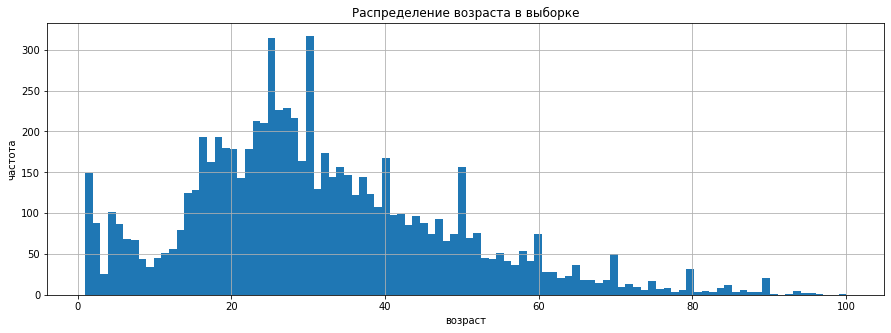

In [8]:
(labels['real_age'].plot(kind = 'hist', bins=100, grid=True, figsize=(15,5))
  .set(title = 'Распределение возраста в выборке', xlabel = 'возраст', ylabel = 'частота'));

1) Аномально много минимальных значений возраста.

2) Так как основное количество фото принадлежит людям с 20 до 40 лет, то после обучения сетка будет лучше определять именно эту группу людей, а не людей с 80+ лет например.

3) На распределении есть пики на "круглых" и "юбилейных" датах. Это может быть связано с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его.

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)  # ImageDataGenerator удобный загрузчик

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),  # к какому размеру приводить изображения 
        batch_size=32,           # размер извлекаемого батча 
        class_mode='raw',        # raw - первозданная метка класса (типо число является числом)
        seed=12345)              # фиксируем генератор случайных чисел

Found 7591 validated image filenames.


In [10]:
features, target = next(train_gen_flow) # получаем пары «картинки — метки» функцией next() (англ. «следующий»)
features.shape

(32, 224, 224, 3)

Получились признаки — четырёхмерный тензор, в котором 32 изображений размером 224, 224 с тремя цветовыми каналами.

**Выведем 15 фотографий на экран:**

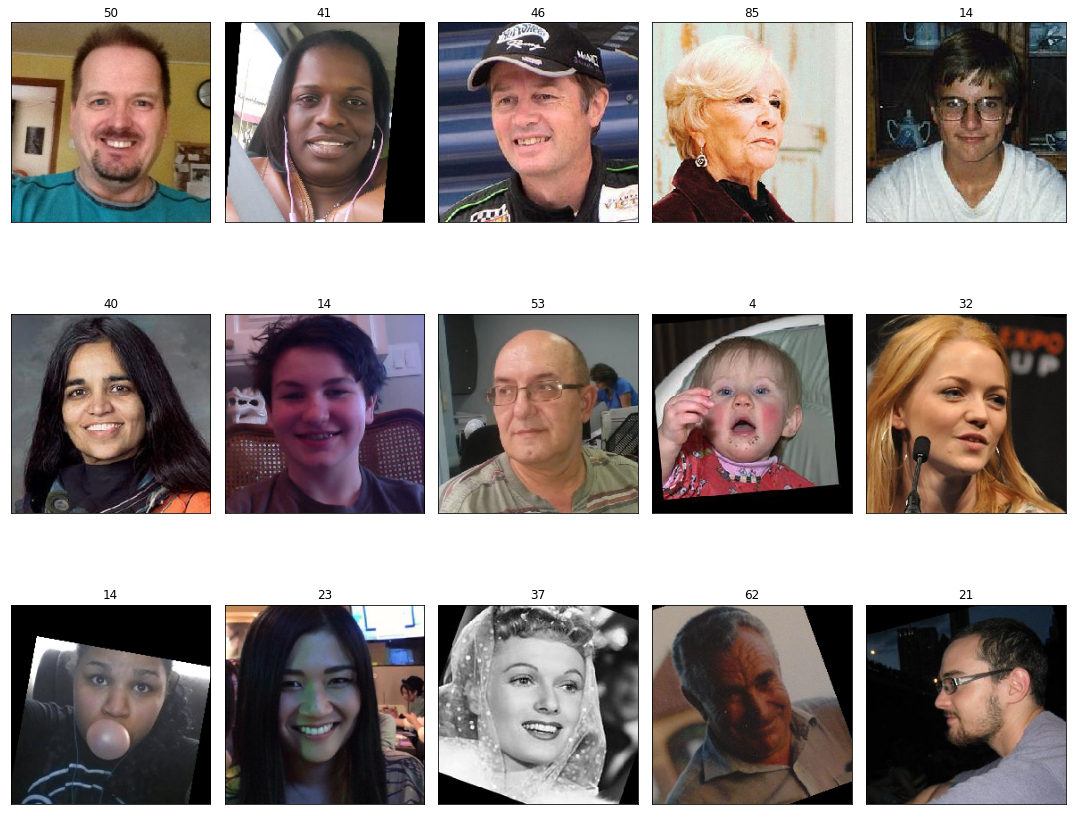

In [11]:
fig = plt.figure(figsize=(15, 15)) # размер фото
for i in range(15):                # количество извлекаемых фото
    fig.add_subplot(3, 5, i+1)     # 3 строки по 5 фото в каждой
    plt.imshow(features[i])        # извлечь картинку 
    plt.title(target[i])           # извлечь метку этой картинки   
    plt.xticks([])                 # удаляем подписи оси x
    plt.yticks([])                 # удаляем подписи оси y
    plt.tight_layout()             # смыкаем изображения друг к другу

Вывод: 

1) Размер датасета: (7591, 2) 7591 - фото, 2 - идентификатор фото + метка возраста.

2) Скорее всего модель будет давать более точные предсказания возраста людей от 20-40 лет, и преимущественно возраст кратный цифре 5.

3) Среди фото много с вращением. Есть изображения в оттенках серого, также присутствует много фото с пониженной яркостью. 

4) Размер данных для обучения позволяет построить модель без заморозки основного слоя сети (таким образом избежать переобучения модели).

## Обучение модели

Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен как ячейка с кодом, но вывод работы кода оформлен в отдельной текстовой ячейке ниже

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50  # ResNet импортируем из Keras
import numpy as np
import pandas as pd


# Функция загрузки обучающей выборки
def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,    # нормировка яркости
                                validation_split=0.25,    # указываем загрузчику, что валидация содержит 25% случайных объектов
                                horizontal_flip=True,     # применяем отражения по горизонтали (по вертикали для фоток не нужно)
                                brightness_range=(0.8, 1.)) # определяет диапазон для случайного выбора значения сдвига яркости
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels, # извлекает данные из папки
      directory=path + 'final_files/',
      x_col='file_name', #название (номер) фото по горизонтали
      y_col='real_age',  # числа возраста по вертикали
      target_size=(224, 224), # нормировка фото по размеру
      batch_size=32,          # размер извлекаемого батча
      class_mode='raw',       # raw - первозданная метка класса (типо число является числом)
      subset='training',      # указываем, что это загрузчик для обучающей выборки
      seed=12345)             # фиксируем генератор случайных чисел
    return train_datagen_flow # Чтобы обучающая и валидационная выборки не содержали общих элементов - seed одинаковое.

# Функция загрузки валидационной выборки
def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', # указываем, что это загрузчик для валидационной выборки
        seed=12345) 
    return test_datagen_flow
# Загружать в эту функцию тестовую выборку не нужно было: сервер загружал её сам. 

# Функция создания модели
def create_model(input_shape): # Чтобы указать размер данных в первом слое, применяем параметр input_shape.

    backbone = ResNet50(input_shape=input_shape, # input_shape - размер входного изображения
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', # инициализация весов
                                        # ImageNet — название датасета, на котором сеть обучалась классифицировать 
                                        # изображения на 1000 классов. 
                    include_top=False)  # в конце архитектуры ResNet нет двух стандартных слоев: GlobalAveragePooling2D и Dense.
                                        # Задача регрессии, так что Нужен всего один нейрон, который вернёт число-предсказание. 
                                     # Слой с 1000 нейронов следует просто удалить из сети.
    model = Sequential() # модели задаётся класс Sequential (англ. «последовательный»)
    model.add(backbone)  # backbone (англ. «костяк») — то, что осталось от ResNet50
    
    # архитектуру последних двух слоев конструируем сами:
    model.add(GlobalAveragePooling2D())    #  пулинг с окном во весь тензор. Усреднитель информации по всему изображению
    model.add(Dense(1, activation='relu')) # полносвязный слой 
    optimizer = Adam(lr=0.0002)            # алгоритм градиентного спуска
    model.compile(optimizer=optimizer,loss='mean_squared_error', metrics=['mae']) # нейронки с ф.потерь MSE обучаются быстрее
    return model

# Функция запуска модели
def train_model(model, train_data, test_data, batch_size=None, epochs=12, # выбранное кол-во эпох обучения
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Выводы кода:

In [ ]:
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/12
2023-07-11 09:24:51.438206: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-11 09:24:51.877926: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 63s - loss: 230.9738 - mae: 10.9610 - val_loss: 818.7838 - val_mae: 23.7160
Epoch 2/12
178/178 - 50s - loss: 84.6842 - mae: 6.9411 - val_loss: 376.3788 - val_mae: 14.4384
Epoch 3/12
178/178 - 51s - loss: 60.4114 - mae: 5.8713 - val_loss: 222.9803 - val_mae: 11.6673
Epoch 4/12
178/178 - 52s - loss: 46.3468 - mae: 5.1948 - val_loss: 130.7485 - val_mae: 8.6310
Epoch 5/12
178/178 - 51s - loss: 34.6912 - mae: 4.4854 - val_loss: 97.7007 - val_mae: 7.4751
Epoch 6/12
178/178 - 50s - loss: 28.2260 - mae: 4.0448 - val_loss: 72.0655 - val_mae: 6.3442
Epoch 7/12
178/178 - 51s - loss: 23.0061 - mae: 3.6817 - val_loss: 74.6699 - val_mae: 6.6008
Epoch 8/12
178/178 - 50s - loss: 16.7952 - mae: 3.1554 - val_loss: 79.5347 - val_mae: 6.9593
Epoch 9/12
178/178 - 51s - loss: 14.9210 - mae: 2.9373 - val_loss: 62.0897 - val_mae: 5.8371
Epoch 10/12
178/178 - 51s - loss: 11.9541 - mae: 2.6412 - val_loss: 67.8036 - val_mae: 6.1758
Epoch 11/12
178/178 - 49s - loss: 10.1670 - mae: 2.4431 - val_loss: 64.9964 - val_mae: 6.1149
Epoch 12/12
178/178 - 50s - loss: 9.0220 - mae: 2.2967 - val_loss: 60.5246 - val_mae: 5.8325
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 60.5246 - mae: 5.8325
Test MAE: 5.8325

## Выводы

Все пункты плана работы были выполнены.

1) Был проведен исследовательский анализ данных: выявлено то, что есть фотографии с низкой яркостью и с горизонтальным вращением, следовательно в обучающий датасет добавлены фотографии с такими признаками для повышения качества работы модели.
    
2) Была построена и обучена модель, которая со значением среднего абсолютного отклонения (MAE) **5.8** может спрогнозировать возраст человека на фотографии.

**Описание модели:**\
Предобученная нейросеть **ResNet50** со слоем глобального пуллинга и полносвязным слоем, и дополнительно обученная на данных датасета без замораживания. В качестве функции потерь использовалась mean_squared_error, что немного ускорило процесс обучения.\
**optimizer = Adam(lr=0.0002), эпох - 12.**

Значение метрики, согласованное заказчиком доcтигнуто.

**Дополнительные заметки:**\
Для дальнейшего улучшения качества возможно сделать:

1. Можно использовать только 9 эпох, далее по данным 'val_mae' видно, что mae начинает расти, а значит модель переобучается.
2. Улучшить качество данных на входе: оценить еще раз возраст по фото:
- а) Визуально
- б) Дополнительно изучить распределение целевого признака. Посмотреть, каких возрастных групп представлено мало, чтобы их потом добавить в выборку.
- в) Через ошибки модели - если модель сильно ошибается на сегменте пожилых людей, но почти идеально работает с детьми, то нужно добавить в выборку фото пожилых людей для дообучения.